## A/B Test Analysis: Old vs New Landing Page
The goal is to check if the new landing page improved conversion rates compared to the old one
by analyzing AB test data from Kaggle.

After cleaning mismatched and duplicate entries, conversion rates are calculated, results are visualized, and two-proportion z-test is run. 

Also, 95% confidence intervals (of both control and treatment groups) are compared to assess if the conversion rate results are statistically significant.

Finally, a power analysis (MDE) is included to confirm that the sample size is large enough to detect small differences in conversion rates.

This analysis helps to decide whether the new page performs better or if more data is needed before rollout.


In [16]:
# 1. Import Libraries
# Importing necessary libraries for data handling, visualization, and statistical testing.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

pd.set_option('display.float_format', lambda x: f'{x:.4f}')
sns.set(style='whitegrid', context='notebook')

In [17]:
# 2. Load Dataset
# Loading the dataset and inspecting its basic structure.
df = pd.read_csv('ab_data.csv')
print(f"Data shape: {df.shape}")
df.head()

Data shape: (294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [18]:
# 3. Basic Data Checks
# Checking for missing values, duplicates, and unique group and page combinations.
print(df.info())
print(df.isna().sum())
print("Unique groups:", df['group'].unique())
print("Unique landing pages:", df['landing_page'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64
Unique groups: ['control' 'treatment']
Unique landing pages: ['old_page' 'new_page']


In [19]:
# 4. Data Cleaning
# Removing rows where 'group' and 'landing_page' don't match.
clean_df = df.query('group == "control" and landing_page == "old_page" or group == "treatment" and landing_page == "new_page"')
print(f"After filtering mismatches: {clean_df.shape}")

# Removing duplicate users to keep one record per user.
clean_df = clean_df.drop_duplicates(subset='user_id')
print(f"After removing duplicates: {clean_df.shape}")

After filtering mismatches: (290585, 5)
After removing duplicates: (290584, 5)


In [20]:
# 5. Check Balance Between Groups
# Checking that both groups have roughly equal representation.
group_counts = clean_df['group'].value_counts(normalize=True)
print("\nGroup distribution (proportion):")
print(group_counts)


Group distribution (proportion):
group
treatment   0.5001
control     0.4999
Name: proportion, dtype: float64


In [21]:
# 6. Conversion Rate by Group
# Calculating conversion rates for each group.
conv_summary = clean_df.groupby('group')['converted'].agg(['mean','count'])
conv_summary.rename(columns={'mean': 'conversion_rate', 'count': 'n'}, inplace=True)
print("\nConversion summary:")
print(conv_summary)


Conversion summary:
           conversion_rate       n
group                             
control             0.1204  145274
treatment           0.1188  145310


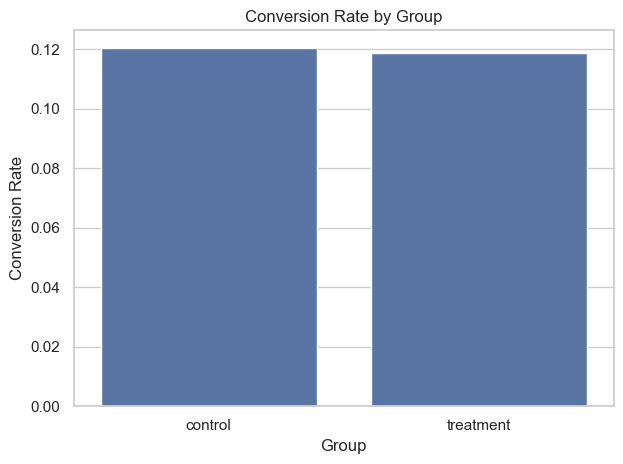

In [36]:
# 7. Visualize Conversion Rates
# Creating a simple bar plot of conversion rates.
import os
os.makedirs("visuals", exist_ok=True)

sns.barplot(x=conv_summary.index, y=conv_summary['conversion_rate'])
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')

plt.tight_layout()
plt.savefig("visuals/conversion_rate_chart.png", dpi=300, bbox_inches="tight")
plt.show()


In [23]:
# 8. Hypothesis Testing
# Performing a two-proportion z-test to check if the difference in conversion rates is statistically significant
convert_counts = clean_df.groupby('group')['converted'].sum().values
nobs = clean_df.groupby('group')['converted'].count().values
z_stat, p_val = proportions_ztest(count=convert_counts, nobs=nobs)
print(f"Z-statistic: {z_stat:.3f}, p-value: {p_val:.4f}")

alpha = 0.05
if p_val < alpha:
    print("Result: Statistically significant difference in conversion rates.")
else:
    print("Result: No statistically significant difference.")

Z-statistic: 1.311, p-value: 0.1899
Result: No statistically significant difference.


In [24]:
# 9. Confidence Intervals for Conversion Rates
# Adding 95% confidence intervals to understand uncertainty
for group in conv_summary.index:
    count = clean_df[clean_df['group']==group]['converted'].sum()
    nobs = clean_df[clean_df['group']==group].shape[0]
    low, high = proportion_confint(count, nobs, alpha=0.05, method='wilson')
    print(f"{group.capitalize()} group 95% CI: ({low:.4f}, {high:.4f})")

Control group 95% CI: (0.1187, 0.1221)
Treatment group 95% CI: (0.1172, 0.1205)


In [32]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Baseline (control) conversion rate
p1 = conv_summary.loc['control', 'conversion_rate']
# Assume we want to detect a 1% absolute increase
p2 = p1 + 0.01  

# Calculate effect size and required sample
effect_size = proportion_effectsize(p1, p2)
analysis = NormalIndPower()
sample_needed = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8)

print(f"Required sample size per group to detect a 1% lift: {sample_needed:.0f}")
print(f"Current sample per group: {conv_summary['n'].iloc[0]:.0f}")

Required sample size per group to detect a 1% lift: 17209
Current sample per group: 145274


### Results

The control group converted at **12.04%**, and the new page (treatment) at **11.88%**.  
The p-value is **0.19**, so the difference isn’t statistically significant.  
The 95% confidence intervals overlap (Control: 0.1187–0.1221, Treatment: 0.1172–0.1205),  
showing the small drop in performance could be random.  
The sample size (~145K users per group) is well above the ~17K required to detect a 1% lift,  
so the test had enough power to identify meaningful changes.

### Interpretation and Recommendation

The new page converted slightly lower than the old one, but the difference isn’t statistically significant.  
There’s no evidence of improvement, keeping the current page as is and testing different change ideas would be beneficial.